In [2]:
import numpy as np 
import pickle
import casadi as cs
import matplotlib.pyplot as plt 

# MPC

## Load simulated data

In [5]:
def load():
    f = open(
        '/home/lars/crane_ws/src/crane/crane_controllers/data/datain.pickle', 'rb')
    datain = pickle.load(f)
    f.close()
    f = open(
        '/home/lars/crane_ws/src/crane/crane_controllers/data/dataout.pickle', 'rb')
    dataout = pickle.load(f)
    f.close()
    return datain, dataout

In [6]:
datain, dataout = load()

last_gopts = datain['last_gopt']
last_gs = datain['last_g']
Ls = datain['L']
ks = datain['k']
gammas = datain['gamma']
ts = datain['t']
zrefs = datain['zref']
zs = datain['z']

dot_wxs = dataout['dot_wx']
dot_wys = dataout['dot_wy']
gxs = dataout['gx']
gys = dataout['gy']

In [7]:
def cs_continuous_dynamics():
    kp = cs.SX.sym('kp')
    kd = cs.SX.sym('kd')
    k = cs.vertcat(kp, kd)
    
    L = cs.SX.sym('L')

    x0 = cs.SX.sym('x0')
    dx0 = cs.SX.sym('dx0')
    y0 = cs.SX.sym('y0')
    dy0 = cs.SX.sym('dy0')
    phix = cs.SX.sym('phix')
    dphix = cs.SX.sym('dphix')
    phiy = cs.SX.sym('phiy')
    dphiy = cs.SX.sym('dphiy')
    z = cs.vertcat(x0, dx0, y0, dy0, phix, dphix, phiy, dphiy)
    
    cx = cs.SX.cos(phix)
    sx = cs.SX.sin(phix)
    cy = cs.SX.cos(phiy)
    sy = cs.SX.sin(phiy)
    
    gx = cs.SX.sym('gx')
    gy = cs.SX.sym('gy')
    g = cs.vertcat(gx, gy)

    dzdt = cs.SX.sym('dzdt', 8,1)

    uy = - L*cy/cx*(kd*dphix + kp*phix) - 2.0*L*sy / \
        cx*dphix*dphiy + 9.81*sx*sy*sy/cx

    # Eq 51-54 in Ecc
    dzdt[0] = dx0  # dx0
    dzdt[1] = gx + (L*(kd*dphiy + kp*phiy) - L*cy*sy *
                    dphix*dphix - uy*sx*sy)/cy  # ddx0
    dzdt[2] = dy0  # dy0
    dzdt[3] = gy - (L*cy*(kd*dphix + kp*phix) + 2.0*L*sy *
                    dphix*dphiy - 9.81*sx*sy*sy)/cx  # ddy0
    dzdt[4] = z[5]  # dphix
    dzdt[5] = (-kd*dphix) - (kp*phix) - \
        (9.81/L*cy*sx) + (gy*cx/(cy*L))  # ddphix
    dzdt[6] = z[7]  # dphiy
    dzdt[7] = (-kd*dphiy) - (kp*phiy) - (9.81 / L * cx*sy) - \
        ((gx*cy + gy*sx*sy)/L)  # ddphiy
    
    f = cs.Function('cs', [z, g, k, L], [dzdt], ['z', 'g', 'k', 'L'], ['dzdt'])
    return f

In [12]:
def cs_discrete_dynamics():
    zk = cs.SX.sym('zk', 8)
    zk1 = cs.SX.sym('zk1', 8)
    gk = cs.SX.sym('gk', 2)
    Ts = cs.SX.sym('Ts')
    k = cs.SX.sym('k', 2)
    L = cs.SX.sym('L')
    
    cd = cs_continuous_dynamics()
    
    M = 10
    delta = Ts/M
    zk1 = zk
    for i in range(M):
        zk1 += delta * cd(zk1, gk, k, L)
    
    f = cs.Function('dd', [zk, gk, Ts, k, L], [zk1], ['zk', 'gk', 'Ts', 'k', 'L'], ['zk1'])
    return f

In [13]:
cd = cs_continuous_dynamics()
dd = cs_discrete_dynamics()

In [14]:
idx = 99
z = zs[idx]
g = last_gs[idx]
k = ks[idx]
L = Ls[idx]
Ts = 0.2
cd(z, g, k, L)

DM([-0.243796, 0.129262, -0.273322, 0.0403891, 0.002603, -0.463153, 0.0455681, 0.46586])

In [15]:
dd(z, g, Ts, k, L)

DM([1.16374, -0.201903, -0.176003, -0.249514, 0.0467427, -0.0715233, -0.047031, 0.112189])

In [67]:
def cs_objective_function():
    
    z = cs.SX.sym('z', 8)
    zk = z
    zk1 = cs.SX.sym('zk1', 8)
    zref = cs.SX.sym('zref', 8)
    g = cs.SX.sym('g',4,2)
    last_g = cs.SX.sym('last_g',2)
    gk = cs.SX.sym('gk', 2)
    Ts = cs.SX.sym('Ts')
    k = cs.SX.sym('k', 2)
    L = cs.SX.sym('L')
    N = cs.SX.sym('N')
    
    R = cs.SX(np.diag([0.1, 0.1]))
    Q = cs.SX(np.diag([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]))
    
    discrete_dynamics = cs_discrete_dynamics()
    
    gmin = cs.SX(np.ones((4,2)) * -0.1)
    gmax = cs.SX(np.ones((4,2)) * 0.1)
    
    J = cs.SX(0)
    
    gk = g[0,:].T
    zk1 = discrete_dynamics(zk, gk, Ts, k, L)
    J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - last_g).T, R, (gk - last_g)])
    zk = zk1
    
    gk = g[1,:].T
    zk1 = discrete_dynamics(zk, gk, Ts, k, L)
    J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[0,:].T).T, R, (gk - g[0,:].T)])
    zk = zk1
    
    gk = g[2,:].T
    zk1 = discrete_dynamics(zk, gk, Ts, k, L)
    J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[1,:].T).T, R, (gk - g[1,:].T)])
    zk = zk1
    
    gk = g[3,:].T
    zk1 = discrete_dynamics(zk, gk, Ts, k, L)
    J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[2,:].T).T, R, (gk - g[2,:].T)])
    
    
    
    
    
    f = cs.Function('cost', [g, z, Ts, N, zref, k, last_g, L], [J], 
                    ['g', 'z', 'Ts', 'N', 'zref', 'k', 'last_g', 'L'], ['J'] )
    return f
        
    
obj = cs_objective_function()
idx = 1233
obj(last_gopts[:,:,idx], zs[idx], 0.2, 4, zrefs[idx], ks[idx], last_gs[idx], Ls[idx])

DM(0.0896133)

In [64]:
last_gopts[:,:,999]
zs[999]

array([ 1.23921456e+00,  1.25903784e-02, -7.58642877e-02,  1.95571693e-02,
       -4.46135166e-04,  1.97356894e-02, -1.46582321e-03,  8.57119857e-04])

In [73]:
obj

Function(cost:(g[4x2],z[8],Ts,N,zref[8],k[2],last_g[2],L)->(J) SXFunction)

In [74]:
last_gopts[:,:,idx]

array([[-0.01791241,  0.1       ],
       [-0.01703381,  0.1       ],
       [-0.01939254,  0.1       ],
       [-0.0215834 ,  0.1       ]])

In [181]:
idx = 2499

t = ts[idx]
samptime = 0.6

last_g = cs.SX(last_gs[idx])

z = cs.SX(zs[idx])
zk = z
Ts = 0.2
N = 4
zref = cs.SX(zrefs[idx])
k = cs.SX(ks[idx])
last_g = cs.SX(last_gs[idx])
L = cs.SX(Ls[idx])

g = cs.SX.sym('g',8)

R = cs.SX(np.diag([0.1, 0.1]))
Q = cs.SX(np.diag([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]))

discrete_dynamics = cs_discrete_dynamics()

J = cs.SX(0)

gk = g[0:2]
zk1 = discrete_dynamics(zk, gk, Ts, k, L)
J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - last_g).T, R, (gk - last_g)])
zk = zk1

gk = g[2:4]
zk1 = discrete_dynamics(zk, gk, Ts, k, L)
J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[0:2]).T, R, (gk - g[0:2])])
zk = zk1

gk = g[4:6]
zk1 = discrete_dynamics(zk, gk, Ts, k, L)
J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[2:4]).T, R, (gk - g[2:4])])
zk = zk1

gk = g[6:8]
zk1 = discrete_dynamics(zk, gk, Ts, k, L)
J = J + cs.mtimes([(zk1 - zref).T, Q, (zk1 - zref)]) + cs.mtimes([(gk - g[4:6]).T, R, (gk - g[4:6])])

nlp = {}                 # NLP declaration
nlp['x']= g              # decision vars
nlp['f'] = J             # objective
# nlp['g'] = g             # constraints

gmin = np.ones(8) * -0.1
gmax = np.ones(8) * 0.1


# Create solver instance
# F = cs.nlpsol('F','sqpmethod',nlp);
F = cs.nlpsol('F','ipopt',nlp);

#     F = cs.qpsol('F', 'qpoases', nlp, {'verbose': True})

# Solve the problem using a guess
sol = np.array(F(x0=last_gopts[:,:,idx].ravel(), lbx=gmin, ubx=gmax )['x']).reshape(-1,2)
print(sol)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [178]:
sol

array([[ 0.0186872 ,  0.02592249],
       [ 0.01312424,  0.03320916],
       [ 0.00287796,  0.0363879 ],
       [-0.00397345,  0.03628527]])

In [151]:
np.array([gxs[idx], gys[idx]])

array([-0.01939254,  0.1       ])

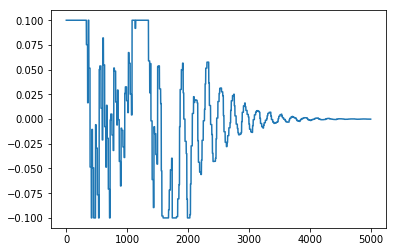

In [155]:
plt.plot(gys)

In [106]:
last_gopts[:,:,idx].ravel()[0:2]

array([-0.01791241,  0.1       ])

In [99]:
last_gopts[:,:,idx]

array([[-0.01791241,  0.1       ],
       [-0.01703381,  0.1       ],
       [-0.01939254,  0.1       ],
       [-0.0215834 ,  0.1       ]])